# Krita - ComfyUI Runtine ติดตั้งโมเดลบน colab V1.0<a href="https://colab.research.google.com/github/SalmonRK/SalmonRK-Colab/blob/main/Krita-ComfyUI/SalmonRK_Krita_comfyui_colab_Runtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

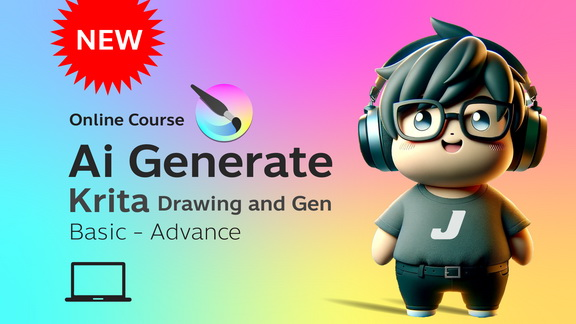

---------------------------------------------------
เปิดแล้วนะครับ กับราคาพิเศษ คอร์ส เรียนรู้กับทำภาพเอไอ บน โปรแกรม Krita Drawing Ai
- สมัครวันนี้เข้ากลุ่มปรึกษาฟรี ทุกเรื่องด้าน เอไอ
- สามารถใช้งานได้บน PC, Notebook บนเครื่องตัวเอง,
- Colab หรือ Cloud service, สอนใช้งาน Runpod ด้วยจ้า
สนใจคลิ๊กเข้าไปดูเนื้อหาได้เลยจ้า
https://www.gorradesign.com/course/detail/krita-drawing-ai-advance

สอบถามรายละเอียดเพิ่มเติมได้ที่
FB : https://www.facebook.com/salmonrkch

# **1. ติดตั้ง Krita-ComfyUI และ โมเดลต่างๆ**
*   สั่งทำงานทุกครั้งเมื่อ ปิดบราวเซอร์
*   เมื่อทำงานเสร็จ ขั้นตอนนี้จะหยุดเองอัติโนมัติ




In [ ]:
import os
import subprocess

!apt -y update -qq
!apt -y install -qq aria2
!pip install -q torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1+cu118 torchtext==0.15.1 torchdata==0.6.0 --extra-index-url https://download.pytorch.org/whl/cu118 -U
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q xformers==0.0.19 triton==2.0.0 -U
!pip install -q mediapipe==0.9.1.0 addict yapf fvcore omegaconf

!git clone https://github.com/comfyanonymous/ComfyUI
%cd /content/ComfyUI
!pip install -q -r requirements.txt
!git reset --hard

##Krita Ai Diffusion
node_dir = "/content/ComfyUI/custom_nodes/"
repositories = [
    ("https://github.com/Fannovel16/comfyui_controlnet_aux", "comfyui_controlnet_aux"),
    ("https://github.com/cubiq/ComfyUI_IPAdapter_plus", "ComfyUI_IPAdapter_plus"),
    ("https://github.com/SalmonRK/ComfyUI_UltimateSDUpscale", "ComfyUI_UltimateSDUpscale"),
    ("https://github.com/Acly/comfyui-inpaint-nodes", "comfyui-inpaint-nodes"),
    ("https://github.com/Acly/comfyui-tooling-nodes", "comfyui-tooling-nodes")
]
for repo_url, dir_name in repositories:
    target_dir = os.path.join(node_dir, dir_name)
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)

##Download Model
%cd /content
!pip install aiohttp tqdm
!wget https://github.com/Acly/krita-ai-diffusion/releases/download/v1.17.1/krita_ai_diffusion-1.17.1.zip
!unzip krita_ai_diffusion-1.17.1.zip
!python /content/ai_diffusion/download_models.py /content/ComfyUI
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/ckpt/OrangeMixs/resolve/main/AOM3.safetensors -d /content/ComfyUI/models/checkpoints -o AOM3.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://civitai.com/api/download/models/143906 -d /content/ComfyUI/models/checkpoints -o epicrealism_naturalSinRC1VAE.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://civitai.com/api/download/models/220771 -d /content/ComfyUI/models/checkpoints -o RyuzakiMixRealistic_V10.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://civitai.com/api/download/models/21173 -d /content/ComfyUI/models/loras -o Colorwater_v4.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://civitai.com/api/download/models/16576 -d /content/ComfyUI/models/loras -o epi_noiseoffset2.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://civitai.com/api/download/models/62833 -d /content/ComfyUI/models/loras -o add_detail.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/stabilityai/sdxl-vae/resolve/main/sdxl_vae.safetensors -d /content/ComfyUI/models/vae -o sdxl_vae.safetensors

!pip install -r /content/ComfyUI/custom_nodes/comfyui_controlnet_aux/requirements.txt
!pip install insightface onnxruntime

## Cloudflare
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /content/cloudflared-linux-amd64 && chmod 777 /content/cloudflared-linux-amd64
import atexit, requests, subprocess, time, re, os
from random import randint
from threading import Timer
from queue import Queue
def cloudflared(port, metrics_port, output_queue):
    atexit.register(lambda p: p.terminate(), subprocess.Popen(['/content/cloudflared-linux-amd64', 'tunnel', '--url', f'http://127.0.0.1:{port}', '--metrics', f'127.0.0.1:{metrics_port}'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT))
    attempts, tunnel_url = 0, None
    while attempts < 10 and not tunnel_url:
        attempts += 1
        time.sleep(3)
        try:
            tunnel_url = re.search("(?P<url>https?:\/\/[^\s]+.trycloudflare.com)", requests.get(f'http://127.0.0.1:{metrics_port}/metrics').text).group("url")
        except:
            pass
    if not tunnel_url:
        raise Exception("Can't connect to Cloudflare Edge")
    output_queue.put(tunnel_url)
output_queue, metrics_port = Queue(), randint(8100, 9000)
thread = Timer(2, cloudflared, args=(8188, metrics_port, output_queue))
thread.start()
thread.join()
tunnel_url = output_queue.get()
os.environ['webui_url'] = tunnel_url
print(tunnel_url)




# **2. เปิด หรือ รีสตาร์ท โปรแกรม**
*   ขั้นตอนนี้ จะทำงานตลอด
* สังเกต จะมี URLอยู่ด้านบน กดเพื่อดูว่าหน้าแอฟ ทำงานได้ปกติหรือไม่
* Copy URL นั้นไปวาง ใน Krita บนเครื่องตนเอง
 Configure -> Connection --> Custom Server


In [ ]:
## Cloudflare
#!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /content/cloudflared-linux-amd64 && chmod 777 /content/cloudflared-linux-amd64
import atexit, requests, subprocess, time, re, os
from random import randint
from threading import Timer
from queue import Queue
def cloudflared(port, metrics_port, output_queue):
    atexit.register(lambda p: p.terminate(), subprocess.Popen(['/content/cloudflared-linux-amd64', 'tunnel', '--url', f'http://127.0.0.1:{port}', '--metrics', f'127.0.0.1:{metrics_port}'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT))
    attempts, tunnel_url = 0, None
    while attempts < 10 and not tunnel_url:
        attempts += 1
        time.sleep(3)
        try:
            tunnel_url = re.search("(?P<url>https?:\/\/[^\s]+.trycloudflare.com)", requests.get(f'http://127.0.0.1:{metrics_port}/metrics').text).group("url")
        except:
            pass
    if not tunnel_url:
        raise Exception("Can't connect to Cloudflare Edge")
    output_queue.put(tunnel_url)
output_queue, metrics_port = Queue(), randint(8100, 9000)
thread = Timer(2, cloudflared, args=(8188, metrics_port, output_queue))
thread.start()
thread.join()
tunnel_url = output_queue.get()
os.environ['webui_url'] = tunnel_url
print(tunnel_url)

##Start Comfy
%cd /content/ComfyUI
!python main.py --dont-print-server

# **Option 1. Download Models , Lora**

In [ ]:
!apt-get -y install -qq aria2
import os
import subprocess

checkpoint = "/content/ComfyUI/models/checkpoints"
Model_URL1 = "https://civitai.com/api/download/models/62528" #@param {type:"string"}
command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {Model_URL1} -d {checkpoint}"
subprocess.run(command, shell=True, check=True)
Model_URL2 = "https://huggingface.co/ckpt/perfect_world/resolve/main/perfectWorld_v2Baked.safetensors" #@param {type:"string"}
command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {Model_URL2} -d {checkpoint}"
subprocess.run(command, shell=True, check=True)


In [ ]:
!apt-get -y install -qq aria2
import os
import subprocess

LORAS = "/content/ComfyUI/models/loras"
LORA_URL1 = "https://civitai.com/api/download/models/62379" #@param {type:"string"}
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {LORA_URL1} -d {LORAS}
LORA_URL2 = "https://civitai.com/api/download/models/135867" #@param {type:"string"}
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {LORA_URL2} -d {LORAS}



# Customized By [SalmonRK] (https://www.facebook.com/salmonrkch)
# 📚 GitHub for more: [_@SalmonRK_](https://github.com/SalmonRK)